# Trying our different learning rate schedules

Using the default network configuration, the goal is to get to the reference valid loss as quickly as possible.

1. Typical learning rate decau
2. One cycle LR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.score import *
from src.train_nn import *
import matplotlib.pyplot as plt

/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/frame

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(1)
limit_mem()

In [4]:
datadir = '/data/stephan/WeatherBench/5.625deg/'
var_dict = {'geopotential': ('z', [500]), 'temperature': ('t', [850])}
output_vars = None
filters = [64, 64, 64, 64, 2]
kernels = [5, 5, 5, 5, 5]
lead_time = 72
batch_size = 128
activation = 'elu'

In [5]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [6]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [7]:
324336 /100000

3.24336

In [8]:
dg_train = DataGenerator(ds_train, var_dict, lead_time, batch_size=batch_size, 
                         output_vars=output_vars, norm_subsample=100000)
dg_valid = DataGenerator(ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
dg_test =  DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
print(f'Mean = {dg_train.mean}; Std = {dg_train.std}')

DG start 08:03:24.787120
DG normalize 08:03:24.802191
DG load 08:03:28.544873
Loading data into RAM
DG done 08:05:07.225423
DG start 08:05:07.225935
DG normalize 08:05:07.233180
DG load 08:05:07.240702
Loading data into RAM
DG done 08:05:08.809661
DG start 08:05:08.811194
DG normalize 08:05:08.818722
DG load 08:05:08.825964
Loading data into RAM
DG done 08:05:10.238713
Mean = <xarray.DataArray 'z' (level: 2)>
array([53999.11   ,   273.80154], dtype=float32)
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U5 'z_500' 't_850'; Std = <xarray.DataArray 'z' (level: 2)>
array([3353.02    ,   15.909879], dtype=float32)
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U5 'z_500' 't_850'


In [9]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([53999.11   ,   273.80154], dtype=float32)
 Coordinates:
   * level        (level) int64 500 850
     level_names  (level) <U5 'z_500' 't_850',
 <xarray.DataArray 'z' (level: 2)>
 array([3353.02    ,   15.909879], dtype=float32)
 Coordinates:
   * level        (level) int64 500 850
     level_names  (level) <U5 'z_500' 't_850')

## Learning rate decay

In [17]:
class LRUpdate(object):
    def __init__(self, init_lr, step, divide):
        # From goo.gl/GXQaK6
        self.init_lr = init_lr
        self.step = step
        self.drop = 1. / divide

    def __call__(self, epoch):
        lr = self.init_lr * np.power(self.drop, np.floor((epoch) / self.step))
        print(f'Learning rate = {lr}')
        return lr

In [32]:
lrs = LRUpdate(1e-3, 2, 5)

Learning rate = [1.0e-03 1.0e-03 2.0e-04 2.0e-04 4.0e-05 4.0e-05 8.0e-06 8.0e-06 1.6e-06
 1.6e-06]


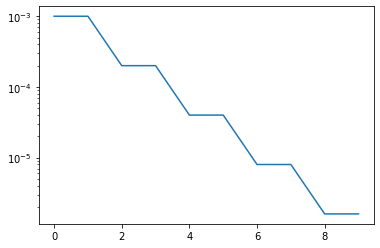

In [33]:
plt.plot(lrs(np.arange(10)))
plt.yscale('log')

In [34]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 64, 2)         0         
_________________________________________________________________
lambda_20 (Lambda)           (None, 36, 68, 2)         0         
_________________________________________________________________
periodic_conv2d_20 (Periodic (None, 32, 64, 64)        3264      
_________________________________________________________________
lambda_21 (Lambda)           (None, 36, 68, 64)        0         
_________________________________________________________________
periodic_conv2d_21 (Periodic (None, 32, 64, 64)        102464    
_________________________________________________________________
lambda_22 (Lambda)           (None, 36, 68, 64)        0         
_________________________________________________________________
periodic_conv2d_22 (Periodic (None, 32, 64, 64)        102464    
__________

In [ ]:
model.fit_generator(dg_train, epochs=100, validation_data=dg_valid, 
                    callbacks=[keras.callbacks.LearningRateScheduler(lrs)])

Learning rate = 0.001
Epoch 1/100
2534/2534 [==============================] - 177s 70ms/step - loss: 8.0596 - val_loss: 7.3410
Learning rate = 0.001
Epoch 2/100
2534/2534 [==============================] - 178s 70ms/step - loss: 7.0196 - val_loss: 6.8583
Learning rate = 0.0002
Epoch 3/100
2534/2534 [==============================] - 178s 70ms/step - loss: 6.5630 - val_loss: 6.6140
Learning rate = 0.0002
Epoch 4/100
1947/2534 [======================>.......] - ETA: 40s - loss: 6.4614

## One Cycle

In [44]:
from src.clr import LRFinder
import seaborn as sns
sns.set_style('darkgrid')

In [19]:
dg_train.n_samples, batch_size

(324264, 128)

In [29]:
lrf = LRFinder(
    dg_train.n_samples, batch_size,
    minimum_lr=1e-4, maximum_lr=10,
    lr_scale='exp', save_dir='./', verbose=0)

In [30]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

In [31]:
model.fit_generator(dg_train, epochs=1, 
                    callbacks=[lrf])

Epoch 1/1
1009/2534 [==========>...................] - ETA: 1:47 - loss: 568.1512

KeyboardInterrupt: 

(6, 10)

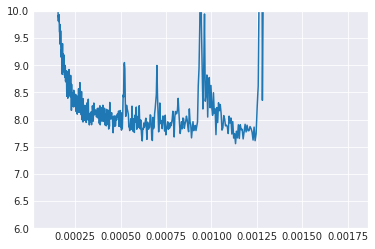

In [45]:
plt.plot(10**lrf.lrs, lrf.losses)
# plt.yscale('log')
plt.ylim(6, 10)

In [81]:
max_lr = 2.5e-4
# max_lr = 5e-4

In [82]:
from src.clr import OneCycleLR

In [83]:
one_cycle = OneCycleLR(max_lr,
    end_percentage=0.1, scale_percentage=None,
#     maximum_momentum=None, minimum_momentum=None
                      )

In [84]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.SGD(), 'mse')

In [85]:
model.fit_generator(dg_train, epochs=5, validation_data=dg_valid, 
                    callbacks=[one_cycle])

Epoch 1/5
2534/2534 [==============================] - 185s 73ms/step - loss: 8.1395 - val_loss: 7.5917
Epoch 2/5
2534/2534 [==============================] - 186s 73ms/step - loss: 7.3380 - val_loss: 7.3206
Epoch 3/5
2534/2534 [==============================] - 185s 73ms/step - loss: 7.0502 - val_loss: 6.9504
Epoch 4/5
2534/2534 [==============================] - 185s 73ms/step - loss: 6.8242 - val_loss: 6.8008
Epoch 5/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.6957 - val_loss: 6.7314


In [88]:
model.fit_generator(dg_train, epochs=5, validation_data=dg_valid, 
                    callbacks=[one_cycle])

Epoch 1/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.6846 - val_loss: 6.7612
Epoch 2/5
2534/2534 [==============================] - 185s 73ms/step - loss: 6.6886 - val_loss: 6.7185
Epoch 3/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.6221 - val_loss: 6.6198
Epoch 4/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.4922 - val_loss: 6.5067
Epoch 5/5
2534/2534 [==============================] - 186s 73ms/step - loss: 6.4067 - val_loss: 6.4583


In [89]:
one_cycle = OneCycleLR(max_lr,
    end_percentage=0.1, scale_percentage=None,
    maximum_momentum=None, minimum_momentum=None
                      )

In [90]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

In [ ]:
model.fit_generator(dg_train, epochs=5, validation_data=dg_valid, 
                    callbacks=[one_cycle])

Epoch 1/5
2380/2534 [===========================>..] - ETA: 11s - loss: 9.0376

In [ ]:
model.fit_generator(dg_train, epochs=5, validation_data=dg_valid, 
                    callbacks=[one_cycle])

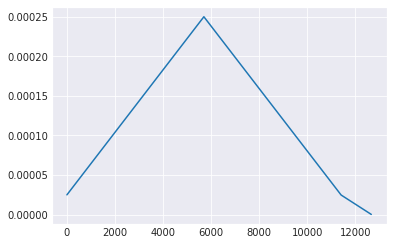

In [86]:
plt.plot(one_cycle.history['lr'])

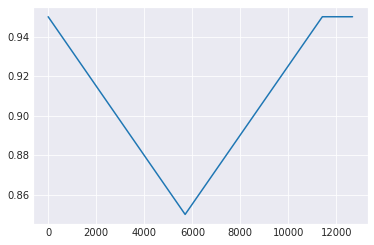

In [87]:
plt.plot(one_cycle.history['momentum'])